In [459]:
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from bokeh.models import ColumnDataSource
from bokeh.palettes import Category20
from bokeh.plotting import figure,show
from bokeh.models import Span
from bokeh.transform import factor_cmap
from bokeh.io import show
from bokeh.models import CustomJS, Slider, TextInput
from bokeh.models.widgets.inputs import NumericInput
from bokeh.io import output_notebook
from bokeh.layouts import row,column, gridplot
from bokeh.plotting import figure
from bokeh.io import curdoc
from bokeh.models import ColumnDataSource, TableColumn, DataTable,Div
import pandas as pd
from bokeh.models import ColorBar, LinearColorMapper,BasicTicker, PrintfTickFormatter,NumberFormatter
from bokeh.transform import transform
from string import Template
output_notebook()

Loading BokehJS ...

# Filtering loan applications with content, context and interaction data

# Goals and tasks

* IPF would like to understand how to use the data collected by MANU Analytics to enhance the screening of the applications and applicants for a loan.
* For this purpose, a dataset of the form contents, usage context and interactions has been collected.
* The prediction power of that dataset has been tested by combining the collected data with.


# Method and Data

* We collected form content and interaction data from the loan application form.
* We combined our collected data with loan acceptance data provided by IPF.
* Only data from fields that are personally non-identifiable data were used in the training and testing.
* In total over 4000 features were collected, from which about 50 features seem to have a strong correlation with the acceptance of the application.
* We trained the model with 80% of the randomly selected data that also was stratified. The model was tested it with the remaining 20% of the data.
* The performance is measured with following metrics: ROC AUC and Average precision (PR AUC)

# Results
* The collected data seem to predict very well the acceptance rate of the application and the collected behavioral data further improves the numbers.
* When using the best content, context and interaction features, the ROC AUC was 0,945 and average precision was 0,854.
* Confusion matrix shown on the right.

# How to utilize the results?
* The resulting model can be used as a pre-screening for the loan applications in order to avoid higher costs of application processing.
* We can minimize the number of false negatives and filter all true negatives to save costs.
* For example, with this approach we could filter 44,7% of all applications as rejected (true negatives) with the use of this model, if we allow rejection of 2,1% of the currently accepted cases (false negatives).
* The model could also be used to predict most potential loan applicants from the visitors of the first pages of the loan application for retargeting or other marketing activities.

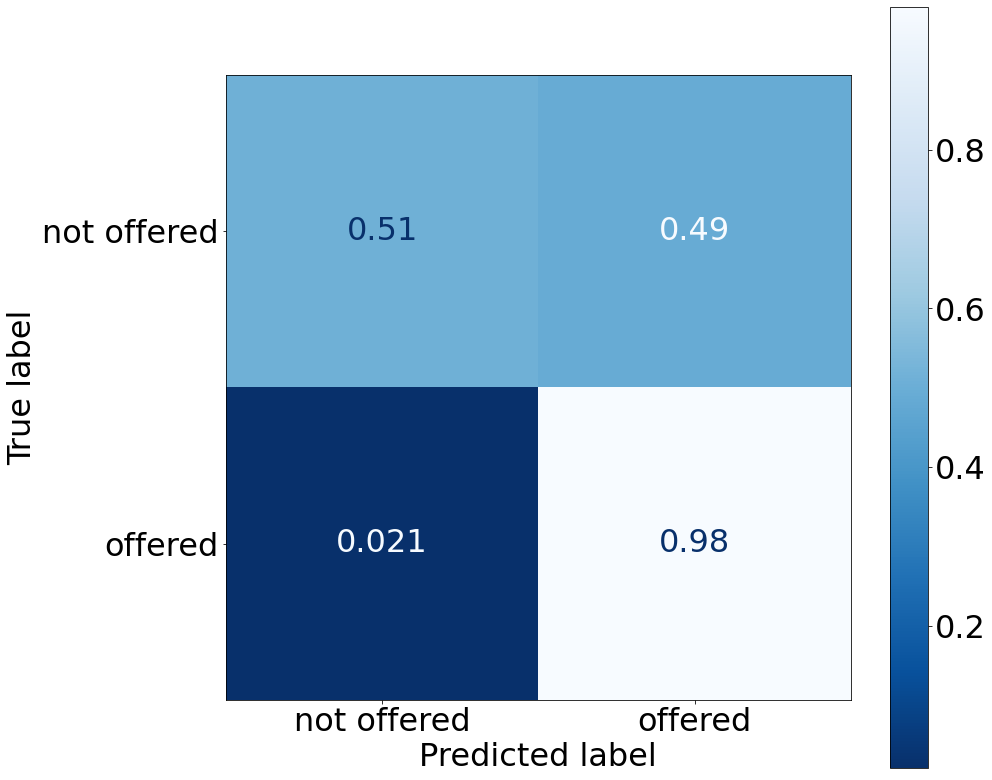

In [51]:
print('\n')
print('\n')
plt.rcParams['font.size'] = '32'
confusion_matrix = np.array([[0.51,0.49],[0.021,0.98]])
matrix = ConfusionMatrixDisplay(confusion_matrix,display_labels=['not offered','offered'])
fig, ax = plt.subplots(figsize=(14,14))
matrix.plot(cmap='Blues_r',ax=ax)
plt.show()

In [461]:
conf_matrices = {'0': [[0.0, 1.0], [0.0, 1.0]],
 '5': [[0.31815685915621855, 0.6818431408437815],
  [0.00779532280631621, 0.9922046771936838]],
 '10': [[0.5141392880021964, 0.4858607119978036],
  [0.020787527483509895, 0.9792124725164901]],
 '15': [[0.6240047588542144, 0.37599524114578564],
  [0.03877673395962423, 0.9612232660403758]],
 '20': [[0.7024800951770843, 0.29751990482291574],
  [0.05676594043573856, 0.9432340595642614]],
 '25': [[0.7599066532442573, 0.24009334675574265],
  [0.07295622626424146, 0.9270437737357585]],
 '30': [[0.8052988011348037, 0.1947011988651963],
  [0.09094543274035578, 0.9090545672596442]],
 '35': [[0.8429578109270615, 0.1570421890729386],
  [0.10553667799320408, 0.8944633220067959]],
 '40': [[0.8715566944266496, 0.1284433055733504],
  [0.12172696382170697, 0.878273036178293]],
 '45': [[0.8963118879838932, 0.10368811201610689],
  [0.14231461123326006, 0.8576853887667399]],
 '50': [[0.915484579482017, 0.08451542051798298],
  [0.15850489706176293, 0.841495102938237]],
 '55': [[0.9315914706689851, 0.06840852933101492],
  [0.17329602238656805, 0.826703977613432]],
 '60': [[0.9444495286903999, 0.05555047130960007],
  [0.18948630821507095, 0.810513691784929]],
 '65': [[0.9548366431774503, 0.04516335682254965],
  [0.2052768338996602, 0.7947231661003398]],
 '70': [[0.9626155394893383, 0.03738446051066167],
  [0.2230661603038177, 0.7769338396961822]],
 '75': [[0.9688386565388487, 0.031161343461151278],
  [0.24265440735558666, 0.7573455926444134]],
 '80': [[0.974100851102773, 0.025899148897227053],
  [0.26584049570257845, 0.7341595042974215]],
 '85': [[0.976663311064336, 0.02333668893566395],
  [0.2972216669998001, 0.7027783330001999]],
 '90': [[0.9797291113754919, 0.0202708886245081],
  [0.33539876074355385, 0.6646012392564461]],
 '95': [[0.9845794820170221, 0.015420517982977944],
  [0.4557265640615631, 0.5442734359384369]],
 '100': [[1.0, 0.0], [1.0, 0.0]]}

In [517]:


data = {'applications':[783658],
        'offer_rate': [19.6],
        'onboarding':[9],
        'aiv':[437],
        'acc_rate':[38.51],
       'cut_off':[0.2]}
dconf = pd.DataFrame({'x': ["offered", "offered","not offered","not offered"],
                   'y':["not offered", "offered","not offered", "offered"],
                  'value':['{:0.3f}'.format(conf_matrices['50'][0][1]),
                           '{:0.3f}'.format(conf_matrices['50'][1][1]),
                          '{:0.3f}'.format(conf_matrices['50'][0][0]),
                          '{:0.3f}'.format(conf_matrices['50'][1][0])]})
                
current_cost = round(data['onboarding'][0]*data['applications'][0],0) #B1*B2
future_cost =  round(float(dconf['value'][1])*(data['offer_rate'][0]/100)*data['applications'][0]*data['onboarding'][0]+
                    float(dconf['value'][0])*((100-data['offer_rate'][0])/100)*data['applications'][0]*data['onboarding'][0] ,0) #=(B2*B1*C9*B3)+(B1*(1-B2)*C8*B3)

rejection_loss = round(data['offer_rate'][0]*data['applications'][0]*float(dconf['value'][3])*data['aiv'][0]*data['acc_rate'][0]/100**2,0) #B1*B2*B9*B4*B5
total_boarding = future_cost + rejection_loss
total_savings  = current_cost - total_boarding    
df = pd.DataFrame({
    'SubjectID': ['Total onboarding now',
                  'Onboarding with filtering',
                  'Customer rejection loss',
                  'Total costs with filtering',
                  'Potential savings before MANU cost'             
                 ],
    'value': [current_cost,
              future_cost,
              rejection_loss,
              total_boarding,
              total_savings]
})

params = ColumnDataSource(data)
result = ColumnDataSource(df)
source = ColumnDataSource(dconf)
matrices = ColumnDataSource(conf_matrices)

t = Template("""   function update_data(result, params, conf) {
   var results = result.data;

   
   var current_cost = Math.round(params.data['onboarding'][0]*params.data['applications'][0],0);
   var future_cost =  Math.round(conf.data['value'][1]*(params.data['offer_rate'][0]/100)*params.data['applications'][0]*params.data['onboarding'][0]+
                     conf.data['value'][0]*((100-params.data['offer_rate'][0])/100)*params.data['applications'][0]*params.data['onboarding'][0] ,0);
   var rejection_loss = Math.round(params.data['offer_rate'][0]*params.data['applications'][0]*params.data['aiv'][0]*params.data['acc_rate'][0]*conf.data['value'][3]/(100*100),0);
   var total_boarding = future_cost + rejection_loss;
   var total_savings  = current_cost - total_boarding;    
   results['value'][0] = current_cost;
   results['value'][1] = future_cost;
   results['value'][2] = rejection_loss;
   results['value'][3] = total_boarding;
   results['value'][4] = total_savings;
   params.change.emit();
   result.change.emit();
   }
   console.log('text_input: value=' + this.value, this.toString())
   params.data[$variable][0] = this.value
   update_data(result, params, conf)
""")
cut_off = Slider(start=0, end=1, value=data['cut_off'][0], step=.05, title="Model cut off")
cut_off.js_on_change("value", CustomJS(args=dict(result=result,params=params,conf=source,matrices=matrices),code="""
   function update_data(result, params, conf) {
   var results = result.data;

   
   var current_cost = Math.round(params.data['onboarding'][0]*params.data['applications'][0],0);
   var future_cost =  Math.round(conf.data['value'][1]*(params.data['offer_rate'][0]/100)*params.data['applications'][0]*params.data['onboarding'][0]+
                     conf.data['value'][0]*((100-params.data['offer_rate'][0])/100)*params.data['applications'][0]*params.data['onboarding'][0] ,0);
   var rejection_loss = Math.round(params.data['offer_rate'][0]*params.data['applications'][0]*params.data['aiv'][0]*params.data['acc_rate'][0]*conf.data['value'][3]/(100*100),0);
   var total_boarding = future_cost + rejection_loss;
   var total_savings  = current_cost - total_boarding;    
   results['value'][0] = current_cost;
   results['value'][1] = future_cost;
   results['value'][2] = rejection_loss;
   results['value'][3] = total_boarding;
   results['value'][4] = total_savings;
   params.change.emit();
   result.change.emit();
   }
   
   var index = Math.round(this.value*100,0)
   var selected =  matrices.data[index];
   conf.data['value'] = [selected[0][1].toPrecision(3),selected[1][1].toPrecision(3),
                           selected[0][0].toPrecision(3),selected[1][0].toPrecision(3)];
   update_data(result,params,conf);
   
   conf.change.emit();
   console.log('slider: value=' + conf.data['value'], this.toString())
"""))

applications = NumericInput(value=data['applications'][0], title="Amount of applications",width=180)
applications.js_on_change("value", CustomJS(args=dict(result=result,params=params,conf=source)
                                            ,code=t.substitute({'variable':"'applications'"})) )
offer_rate = NumericInput(value=data['offer_rate'][0], title="Offer rate %",mode='float',width=180)
offer_rate.js_on_change("value", CustomJS(args=dict(result=result,params=params,conf=source)
                                            ,code=t.substitute({'variable':"'offer_rate'"})) )

onboarding_cost = NumericInput(value=data['onboarding'][0], title="Onboarding cost per customer",mode='float',width=180)
onboarding_cost.js_on_change("value", CustomJS(args=dict(result=result,params=params,conf=source)
                                               ,code=t.substitute({'variable':"'onboarding'"})) )
aiv = NumericInput(value=data['aiv'][0], title="Customer value",mode='float',width=180)
aiv.js_on_change("value", CustomJS(args=dict(result=result,params=params,conf=source)
                                               ,code=t.substitute({'variable':"'aiv'"})) )
acc_rate = NumericInput(value=data['acc_rate'][0], title="Offer acceptance rate %",mode='float',width=180)
acc_rate.js_on_change("value", CustomJS(args=dict(result=result,params=params,conf=source)
                                         ,code=t.substitute({'variable':"'acc_rate'"})) )
style = Div(text="""
<style>
.slick-header-column {
            background-color: white !important;
            background-image: none !important;
            }

.slick-row {
            background-color: white !important;
            background-image: none !important;
            color:black !important;
            font-size: 15px;
            
}

.bk-cell-index {
            background-color: white !important;
            background-image: none !important;
            color:black !important;
}
</style>
""")
mapper = LinearColorMapper(palette='Blues256', low=0, high=1)
text_mapper=LinearColorMapper(palette=('white','black'), low=0, high=1)
factors = ["not offered", "offered"]
x = ["offered", "not offered"]
y = ["not offered", "offered"]



p = figure(title="Confusion matrix", tools="hover", toolbar_location=None,
           y_range=["offered","not offered"], x_range=["not offered", "offered"],plot_width=350, plot_height=250)
p.title.text_font_size="12pt"

p.xaxis.axis_label_text_font_size = "10pt"
p.xaxis.major_label_text_font_size = "8pt"
p.yaxis.axis_label_text_font_size = "10pt"
p.yaxis.major_label_text_font_size = "8pt"
p.xaxis[0].axis_label = 'Predicted label'
p.yaxis[0].axis_label = 'True label'

p.rect("x", "y", source=source, width=1, height=1,fill_color={'field': 'value', 'transform': mapper},
       line_color=None)
p.text(x="x", y="y", text='value',source=source,text_font_size='14pt',x_offset=-15,y_offset=10,text_color={'field': 'value', 'transform': text_mapper})
p.add_layout(labels)
color_bar = ColorBar(color_mapper=mapper, major_label_text_font_size="14px",
                     ticker=BasicTicker(desired_num_ticks=4),
                     formatter=PrintfTickFormatter(format="%0.2f"),
                     label_standoff=6, border_line_color=None)
p.add_layout(color_bar, 'right')
div = Div(text="",
width=200, height=50)
columns = [
    TableColumn(field='SubjectID', title=''),
    TableColumn(field='value', title='€',formatter=NumberFormatter(format='0,0000[.]00',text_align='right', language='fi'))
    ]

data_table = DataTable(source=result, autosize_mode='fit_columns',width=400,columns=columns,index_position=None,editable=False,header_row=True,sortable=False,css_classes=["my_table"])

show(row(column(applications,offer_rate,onboarding_cost,aiv,acc_rate),column(cut_off,p),column(div,data_table,style)))

# Further improvements
* Analyze the application filling process if it can be streamlined or if some of the variables are meaningful for the filtering or not
* Data collection of the interactions on loan amount field/slider.
* Model could be also trained and tested to predict those customers that accept the loan offer in order to further enhance the process and possibly save costs.